In [70]:
import random
import torch
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [71]:
import torch.nn as nn

def create_hidden_layers(hidden_layer_sizes):
    if not hidden_layer_sizes:
        return []

    hidden_layers = []
    for i in range(1, len(hidden_layer_sizes)):
        hidden_size = hidden_layer_sizes[i]
        hidden_layers.append(nn.Linear(hidden_layer_sizes[i - 1], hidden_size))
    return hidden_layers


class MultiHiddenLayerNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_sizes, activation_function=torch.relu):
        super(MultiHiddenLayerNetwork, self).__init__()

        self.activation_function = activation_function

        if not hidden_layer_sizes:
            self.input_layer = nn.Linear(input_size, output_size)
            hidden_layers = []
        else:
            self.input_layer = nn.Linear(input_size, hidden_layer_sizes[0])
            hidden_layers = create_hidden_layers(hidden_layer_sizes)
            hidden_layers.append(nn.Linear(hidden_layer_sizes[-1], output_size))

        self.hidden_layers = nn.ModuleList(hidden_layers)

    def pass_forward(self, x):

        x = self.input_layer(x)
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = self.activation_function(x)
            x = hidden_layer(x)
        return x


# Network that takes in all the input features and outputs a vector of qualities
class QualitiesPredictor(MultiHiddenLayerNetwork):
    def __init__(self, input_size, num_quality_scores, hidden_layer_sizes):
        super(QualitiesPredictor, self).__init__(input_size, num_quality_scores, hidden_layer_sizes)

    def forward(self, x):
        return super().pass_forward(x)


# Network that takes a quality and the price and predicts the satisfaction
class SatisfactionPredictor(MultiHiddenLayerNetwork):
    def __init__(self, hidden_layer_sizes):
        super(SatisfactionPredictor, self).__init__(2, 1, hidden_layer_sizes)

    def forward(self, q, p):
        # print("Q", q.size())
        # print("P", p.size())
        x = torch.cat((q, p), dim=1)
        # print(x)
        return super().pass_forward(x)


# Takes all the quality scores and predicts a total quality variable
class TotalQualityPredictor(MultiHiddenLayerNetwork):
    def __init__(self, num_quality_scores, hidden_layer_sizes):
        super(TotalQualityPredictor, self).__init__(num_quality_scores, 1, hidden_layer_sizes)

    def forward(self, x):
        return super().pass_forward(x)


# class CausalModel(nn.Module):
#     def __init__(self, input_size, num_quality_scores,
#                  qualities_predictor_hidden_layer_sizes,
#                  satisfaction_predictor_hidden_layer_sizes,
#                  total_quality_predictor_hidden_layer_sizes):
#         super(CausalModel, self).__init__()

#         self.num_quality_scores = num_quality_scores

#         self.qualities_predictor_net = QualitiesPredictor(input_size, num_quality_scores,
#                                                           qualities_predictor_hidden_layer_sizes)

#         self.activation_on_quality = nn.Sigmoid()

#         self.satisfaction_predictors = [
#             SatisfactionPredictor(satisfaction_predictor_hidden_layer_sizes) for _ in range(num_quality_scores)
#         ]

#         self.total_quality_predictor = TotalQualityPredictor(num_quality_scores,
#                                                              total_quality_predictor_hidden_layer_sizes)

#         self.total_satisfaction_predictor = SatisfactionPredictor(satisfaction_predictor_hidden_layer_sizes)

#     def forward(self, x, p):

#         # print("x size: ", x.size())
#         qualities = self.qualities_predictor_net(x)
#         qualities = self.activation_on_quality(qualities)
#         # print("qualities size: ", qualities.size())

#         satisfactions_outputs = []
#         for i, sat_predictor in enumerate(self.satisfaction_predictors):

#             one_quality = torch.unsqueeze(qualities[:, i], 1)

#             # print("one quality size: ", one_quality.size())
#             # print("price size: ", p.size())
            
#             satisfactions_outputs.append(sat_predictor(one_quality, p))

#         # print("WHYYYY")
#         satisfactions = torch.cat(satisfactions_outputs, dim=1)

#         # print("HELLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO")
#         # print("satisfactions size: ", satisfactions.size())

#         total_quality = self.total_quality_predictor(qualities)
#         total_quality = self.activation_on_quality(total_quality)

#         # print("total quality size: ", total_quality.size())
#         # print("price size: ", p.size())
#         total_satisfaction = self.total_satisfaction_predictor(total_quality, p)

#         return satisfactions, total_satisfaction, total_quality

#     def loss_function(self, satisfactions, total_satisfaction, satisfactions_targets, total_satisfaction_target):
#         # Define custom loss function
#         criterion = nn.MSELoss(reduction='sum')  # Use Mean Squared Error as the loss criterion
#         # Compute the loss for satisfactions
#         loss_satisfactions = criterion(satisfactions, satisfactions_targets)
#         # Compute the loss for total_satisfaction
#         loss_total_satisfaction = criterion(total_satisfaction, total_satisfaction_target)
#         # Add up the losses with appropriate weights (if desired)
#         total_loss = loss_satisfactions + loss_total_satisfaction

#         return total_loss
    

class CausalModelOnlyTotalQuality(nn.Module):
    def __init__(self, input_size,
                 total_quality_predictor_hidden_layer_sizes,
                 satisfaction_predictor_hidden_layer_sizes):
        super(CausalModelOnlyTotalQuality, self).__init__()

        self.quality_predictor_net = QualitiesPredictor(input_size, 1, total_quality_predictor_hidden_layer_sizes)
        self.activation_on_quality = nn.Sigmoid()
        self.total_satisfaction_predictor = SatisfactionPredictor(satisfaction_predictor_hidden_layer_sizes)

    def forward(self, x, p):
        total_quality = self.activation_on_quality(self.quality_predictor_net(x))
        total_satisfaction = self.total_satisfaction_predictor(total_quality, p)
        return total_satisfaction, total_quality

    def loss_function(self, total_satisfaction, total_satisfaction_target):
        criterion = nn.MSELoss(reduction='sum')  # Use Mean Squared Error as the loss criterion
        loss = criterion(total_satisfaction, total_satisfaction_target)
        return loss

In [72]:
import pandas as pd
from torch.utils.data import Dataset

class CausalDataset(Dataset):
    def __init__(self, df):
        CATEGORIES = ["staff", "facilities", "cleanliness", "comfort", "location"]

        self.X = torch.tensor(df[["stars", "reviews", "rating"] + list(pd.get_dummies(df["city"]).columns)].values).float()
        self.p = torch.tensor(df[["price"]].values).float()
        self.s = torch.tensor(df[CATEGORIES].values).float()
        self.total_s = torch.tensor(df[["rating"]].values).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx, :]
        p = self.p[idx, :]
        s = self.s[idx, :]
        total_s = self.total_s[idx, :]

        return X, p, s, total_s
    

class CausalDatasetOnlyTotalQuality(Dataset):
    def __init__(self, df):
        CATEGORIES = ["staff", "facilities", "cleanliness", "comfort", "location"]

        self.X = torch.tensor(df[["stars", "reviews"] + list(pd.get_dummies(df["city"]).columns)+ CATEGORIES].values).float()
        self.p = torch.tensor(df[["price"]].values).float()
        self.total_s = torch.tensor(df[["rating"]].values).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx, :]
        p = self.p[idx, :]
        total_s = self.total_s[idx, :]

        return X, p, total_s

In [73]:
from torch.utils.data import DataLoader

data = pd.read_csv("data.csv")

# Step 2: Split the dataset into train, test, and validation sets
# Define the ratio for train, test, and validation sets
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Get the number of samples in the dataset
num_samples = len(data)

# Calculate the number of samples for train, test, and validation sets
num_train = int(train_ratio * num_samples)
num_test = int(test_ratio * num_samples)
num_val = num_samples - num_train - num_test

# Shuffle the dataset
indices = np.arange(num_samples)
np.random.shuffle(indices)

# Split the dataset into train, test, and validation sets
train_data = data.iloc[indices[:num_train]]
test_data = data.iloc[indices[num_train:num_train + num_test]]
val_data = data.iloc[indices[num_train + num_test:]]

In [74]:
# train_set = CausalDataset(train_data)
# test_set = CausalDataset(test_data)
# val_set = CausalDataset(val_data)

# train_loader = DataLoader(train_set, batch_size=128)
# test_loader = DataLoader(test_set, batch_size=16)
# val_loader = DataLoader(val_set, batch_size=1)

In [75]:
# CATEGORIES = ["staff", "facilities", "cleanliness", "comfort", "location"]

# print(data[["reviews"]].head())

# NUM_FEATURES = len(data[["stars", "reviews", "rating"] + list(pd.get_dummies(data["city"]).columns)].columns)
# NUM_QUALITY_SCORES = len(data[CATEGORIES].columns)

# # model = CausalModel(NUM_FEATURES, NUM_QUALITY_SCORES, [], [], [])

# model = CausalModel(input_size=NUM_FEATURES, 
#                     num_quality_scores=NUM_QUALITY_SCORES,
#                  qualities_predictor_hidden_layer_sizes=[32, 32],
#                  satisfaction_predictor_hidden_layer_sizes=[4, 4],
#                  total_quality_predictor_hidden_layer_sizes=[8, 8])
# model.float()

# batch_losses = []
# validation_losses = []

In [76]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# num_epochs = 40

# for epoch in range(num_epochs):
#     model.train()

#     for batch_idx, (X, p, target_s, target_total_s) in enumerate(train_loader):
#         # print("X size: ", X.size())

#         # print("p size: ", p.size())
#         # print("s size: ", target_s.size())
#         # print("total_s size: ", target_total_s.size())

#         batch_size = len(p)
        
#         optimizer.zero_grad()
#         s, total_s, _total_quality = model(X, p)
#         loss = model.loss_function(s, total_s, target_s, target_total_s) / batch_size
#         loss.backward()
#         optimizer.step()

#         # Record batch loss
#         batch_loss = loss.item()

#         batch_losses.append(batch_loss)
#         # Print batch loss
#         print('Epoch [{}/{}], Batch [{}/{}], Batch Loss: {:.4f}'
#               .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), batch_loss))

#     model.eval()
#     total_val_loss = 0
#     with torch.no_grad():
#         for val_batch_idx, (val_X, val_p, val_target_s, val_target_total_s) in enumerate(val_loader):
#             batch_size = len(val_p)
#             val_s, val_total_s, _val_total_quality = model(val_X, val_p)
#             val_loss = model.loss_function(val_s, val_total_s, val_target_s, val_target_total_s) / batch_size
#             total_val_loss += val_loss.item()

#     validation_loss = total_val_loss / len(val_loader)
#     validation_losses.append(validation_loss)
#     print('Epoch [{}/{}], Validation Loss: {:.4f}'
#           .format(epoch+1, num_epochs, validation_loss))

In [77]:
# import matplotlib.pyplot as plt

# plt.plot(batch_losses, label='Batch Loss')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.plot(validation_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [78]:
# Train quality predict for just one quality score

train_set_just_one_quality = CausalDatasetOnlyTotalQuality(train_data)
test_set_just_one_quality = CausalDatasetOnlyTotalQuality(test_data)
val_set_just_one_quality = CausalDatasetOnlyTotalQuality(val_data)

train_loader_just_one_quality = DataLoader(train_set_just_one_quality, batch_size=128)
test_loader_just_one_quality = DataLoader(test_set_just_one_quality, batch_size=1)
val_loader_just_one_quality = DataLoader(val_set_just_one_quality, batch_size=128)


CATEGORIES = ["staff", "facilities", "cleanliness", "comfort", "location"]

NUM_FEATURES_JUST_ONE_QUALITY = len(["stars", "reviews"] + list(pd.get_dummies(data["city"]).columns) + CATEGORIES)

model_just_one_quality = CausalModelOnlyTotalQuality(input_size=NUM_FEATURES_JUST_ONE_QUALITY, 
                 total_quality_predictor_hidden_layer_sizes=[64, 128, 64],
                 satisfaction_predictor_hidden_layer_sizes=[8, 8, 4])

model_just_one_quality.float()

batch_losses_just_one_quality = []
validation_losses_just_one_quality = []

optimizer_just_one_quality = torch.optim.Adam(model_just_one_quality.parameters(), lr=0.001)

num_epochs_just_one_quality = 40

for epoch in range(num_epochs_just_one_quality):
    model_just_one_quality.train()

    for batch_idx, (X, p, target_total_s) in enumerate(train_loader_just_one_quality):

        batch_size = len(p)
        
        optimizer_just_one_quality.zero_grad()
        total_s, _total_quality = model_just_one_quality(X, p)
        loss = model_just_one_quality.loss_function(total_s, target_total_s) / batch_size
        loss.backward()
        optimizer_just_one_quality.step()

        # Record batch loss
        batch_loss = loss.item()

        batch_losses_just_one_quality.append(batch_loss)
        # Print batch loss
        print('Epoch [{}/{}], Batch [{}/{}], Batch Loss: {:.4f}'
              .format(epoch+1, num_epochs_just_one_quality, batch_idx+1, len(train_loader_just_one_quality), batch_loss))

    model_just_one_quality.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_batch_idx, (val_X, val_p, val_target_total_s) in enumerate(val_loader_just_one_quality):
            batch_size = len(val_p)
            val_total_s, _val_total_quality = model_just_one_quality(val_X, val_p)
            val_loss = model_just_one_quality.loss_function(val_total_s, val_target_total_s) / batch_size
            total_val_loss += val_loss.item()

    validation_loss = total_val_loss / len(val_loader_just_one_quality)
    validation_losses_just_one_quality.append(validation_loss)
    print('Epoch [{}/{}], Validation Loss: {:.4f}'
          .format(epoch+1, num_epochs_just_one_quality, validation_loss))

Epoch [1/40], Batch [1/20], Batch Loss: 1.1326
Epoch [1/40], Batch [2/20], Batch Loss: 1.0306
Epoch [1/40], Batch [3/20], Batch Loss: 0.9537
Epoch [1/40], Batch [4/20], Batch Loss: 0.7702
Epoch [1/40], Batch [5/20], Batch Loss: 0.5876
Epoch [1/40], Batch [6/20], Batch Loss: 1.1092
Epoch [1/40], Batch [7/20], Batch Loss: 0.9374
Epoch [1/40], Batch [8/20], Batch Loss: 1.0262
Epoch [1/40], Batch [9/20], Batch Loss: 1.8857
Epoch [1/40], Batch [10/20], Batch Loss: 1.2722
Epoch [1/40], Batch [11/20], Batch Loss: 1.0690
Epoch [1/40], Batch [12/20], Batch Loss: 0.9885
Epoch [1/40], Batch [13/20], Batch Loss: 1.3169
Epoch [1/40], Batch [14/20], Batch Loss: 0.7377
Epoch [1/40], Batch [15/20], Batch Loss: 1.0935
Epoch [1/40], Batch [16/20], Batch Loss: 0.9943
Epoch [1/40], Batch [17/20], Batch Loss: 0.8942
Epoch [1/40], Batch [18/20], Batch Loss: 0.9112
Epoch [1/40], Batch [19/20], Batch Loss: 1.2717
Epoch [1/40], Batch [20/20], Batch Loss: 0.9480
Epoch [1/40], Validation Loss: 1.0378
Epoch [2/40

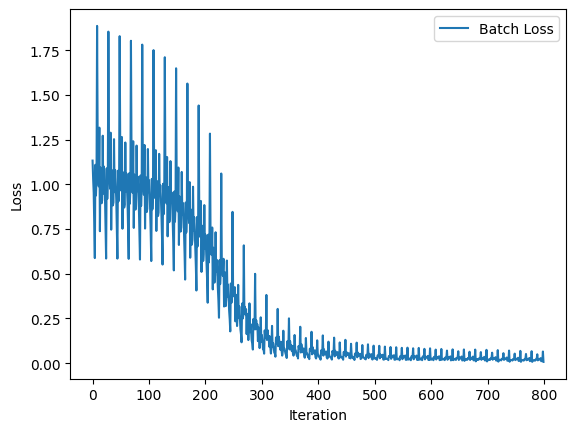

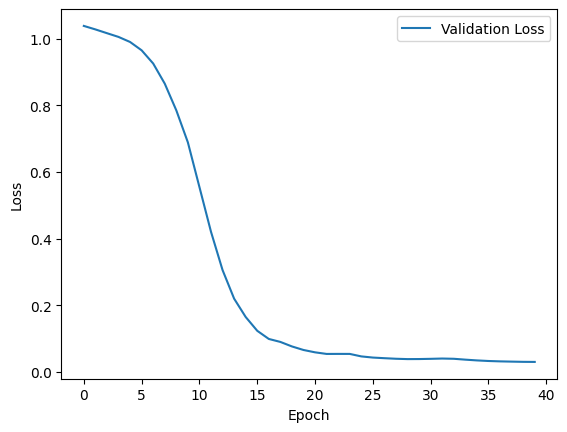

In [79]:
import matplotlib.pyplot as plt

plt.plot(batch_losses_just_one_quality, label='Batch Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(validation_losses_just_one_quality, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
model_just_one_quality.eval()
total_test_loss = 0
with torch.no_grad():
    for test_batch_idx, (test_X, test_p, test_target_total_s) in enumerate(test_loader_just_one_quality):
        batch_size = len(test_p)
        test_total_s, test_total_quality = model_just_one_quality(test_X, test_p)
        test_loss = model_just_one_quality.loss_function(test_total_s, test_target_total_s) / batch_size
        total_test_loss += test_loss.item()

        print("Predicted rating: ", test_total_s)
        print("Actual rating: ", test_target_total_s)
        print("Price: ", test_p)
        print("Predicted quality: ", test_total_quality)

test_loss = total_test_loss / len(test_loader_just_one_quality)
print('Test Loss: {:.4f}'.format(test_loss))

Predicted rating:  tensor([[0.5316]])
Actual rating:  tensor([[0.3944]])
Price:  tensor([[5.6836]])
Predicted quality:  tensor([[0.7669]])
Predicted rating:  tensor([[0.4851]])
Actual rating:  tensor([[0.3944]])
Price:  tensor([[4.5539]])
Predicted quality:  tensor([[0.6889]])
Predicted rating:  tensor([[0.0083]])
Actual rating:  tensor([[0.2983]])
Price:  tensor([[5.2730]])
Predicted quality:  tensor([[0.6491]])
Predicted rating:  tensor([[0.3514]])
Actual rating:  tensor([[0.2983]])
Price:  tensor([[4.9767]])
Predicted quality:  tensor([[0.6862]])
Predicted rating:  tensor([[-0.3000]])
Actual rating:  tensor([[-0.4712]])
Price:  tensor([[4.5951]])
Predicted quality:  tensor([[0.5488]])
Predicted rating:  tensor([[-0.9110]])
Actual rating:  tensor([[-0.9521]])
Price:  tensor([[5.4681]])
Predicted quality:  tensor([[0.5073]])
Predicted rating:  tensor([[0.6793]])
Actual rating:  tensor([[0.6830]])
Price:  tensor([[4.7875]])
Predicted quality:  tensor([[0.7512]])
Predicted rating:  tens